<a href="https://colab.research.google.com/github/hyeonjun/boostcourse_tensorflow/blob/master/lab_12_1_many_to_one_keras_eager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- one to many

특정 이미지를 입력으로 받아 캡션을 생성하는 이미지 캡션 분야에 활용할 수 있다.

- many to many

문장을 입력받아 문장이 출력되는 neural machine translation으로 활용할 수 있다. 또한, 문장을 입력받아 문장의 형태소를 분석해주는 형태소 분석기로도 활용할 수 있다.

* many to one

자연어 처리 분야에서 어떤 문장, 또는 단어를 RNN으로 인코딩하여 해당 문장 또는 단어의 sentiment를 classification하는데 활용할 수 있다.



예를 들어, This movie is good 이라는 sentence가 있다.

sentence의 polarity를 파악하는 문제.

이 문제에서 sentence를 word의 시퀀스로 생각하여, word단위로 sentence를 분해한다.
이 분해를 Tokenization했다고 얘기한다.

이후, RNN을 활용하여 각각의 토큰을 읽고 마지막 토큰을 읽었을 때, polarity를 classification 방식으로 활용하는 것이 many to one의 형태로 RNN을 활용하는 방법 중 하나라고 할 수 있다.

이때 토큰인 word는 숫자가 아니지 때문에 RNN으로 처리할 수가 없다. 그래서 이 토큰을 numeric vector로 바꾸는 연산을 담당하는 Embedding layer가 존재한다. 

이 Embedding layer는 활용하는 방식에 따라 학습할 수도 있고 안할 수도 있다.

Embedding layer가 각각의 토큰을 RNN이 처리할 수 있도록 해주면 RNN은 토큰을 순서대로 읽어들여 마지막 토큰까지 다 읽었을 때 나온 출력과 정답 간의 loss를 계산할 수 있게 된다.

그리고 이 loss를 기반으로 back propagation을 통해 RNN을 학습할 수 있다.


In [ ]:
# Word sentiment class
# - many to one
# - variable input sequence length
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

In [ ]:
# Preparing dataset

# example data
words = ['good', 'bad', 'worse', 'so good']
y_data = [1,0,0,1] # 위 word에 대한 긍(1), 부(0)정 레이블 값

# creating a token dictionary
char_set = ['<pad>']+ sorted(list(set(''.join(words)))) # pad라는 토큰이 추가됨.
"""
pad라는 토큰이 추가되는 이유.
word를 캐릭터의 시퀀스로 간주했을 때 각각의 시퀀스의 길이가 다르기 때문.

딥러닝에서는 batch 단위 연산이 효율적이다.
이를 위해 RNN을 구현할 때 데이터가 서로 다른 시퀀스의 length를 가진 경우
길이를 맞추기 위해 pad와 같은 특별한 토큰을 도입하여 데이터의 시퀀스를 맞춘다.
"""

idx2char = {idx : char for idx, char in enumerate(char_set)}
char2idx = {char : idx for idx, char in enumerate(char_set)}

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [ ]:
# converting sequence of tokens to sequence of indices
x_data = list(map(lambda word : [char2idx.get(char) for char in word], words))
x_data_len = list(map(lambda word : len(word), x_data))

print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [ ]:
# padding the sequence of indices
max_sequence = 10
# max_sequence 값만큼의 길이로 데이터를 padding한다.
# pad_sequences는 기본적으로 0값으로 padding한다.
x_data = pad_sequences(sequences=x_data, maxlen=max_sequence,
                       padding='post', truncating='post')

# checking data
print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


In [ ]:
# Creating model
# creating simple rnn for "many to one" classification
input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))
hidden_size = 10
num_classes = 2

model =Sequential()
# embedding layer는 토큰을 one hot vector로 표현
# one hot vector란 vector의 elements가 특정 토큰의
# integer index 값에 해당하는 부분만 1이고, 나머지는 0인 벡터
# mask_zero=True : 전처리 단계에서 0 값으로 padding된 부분을 알아서 연산에서 제외.
# trainable=False : one hot vector를 트레이닝하지 않을 수 있음.
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim,
                           trainable=False, mask_zero=True, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot)))
# SimpleRNN : 기본적으로 시퀀스의 마지막 토큰을 인풋으로 받아 처리한 결과를 리턴.
model.add(layers.SimpleRNN(units=hidden_size))
# Dense를 이용하여 RNN을 many to one의 방식으로 활용하는 코드 완성.
model.add(layers.Dense(units=num_classes))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 11)            121       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                220       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [ ]:
# Training model
# creating loss function
# classification 문제를 풀고있기 때문에 cross_entropy 계산하는 함수를 활용
# 특히 y가 one hot vector의 형태로 들어오지 않고,
# integer의 형태로 들어오기 때문에 이를 처리할 수 있는
# tf.keras.losses.sparse_categorical_crossentropy를 활용한다.
def loss_fn(model, x, y):
  return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
      y_true=y, y_pred=model(x), from_logits=True
  ))

# creating an optimizer
lr = .01
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
tr_dataset = tr_dataset.shuffle(buffer_size = 4)
tr_dataset = tr_dataset.batch(batch_size=batch_size)

print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.int32, tf.int32)>


In [ ]:
# training
tr_loss_hist = []

for epoch in range(epochs):
  avg_tr_loss = 0
  tr_step = 0

  for x_mb, y_mb in tr_dataset:
    with tf.GradientTape() as tape:
      tr_loss = loss_fn(model, x=x_mb, y=y_mb)
    grads = tape.gradient(target=tr_loss, sources=model.variables)
    opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
    avg_tr_loss += tr_loss
    tr_step+= 1
  if (epoch + 1) % 5 == 0:
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch+1, avg_tr_loss.numpy()))

  else:
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)

epoch :   5, tr_loss : 0.001
epoch :  10, tr_loss : 0.001
epoch :  15, tr_loss : 0.001
epoch :  20, tr_loss : 0.001
epoch :  25, tr_loss : 0.001
epoch :  30, tr_loss : 0.001


In [ ]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1)
print('acc : {:.2%}'.format(np.mean(yhat == y_data)))

acc : 100.00%


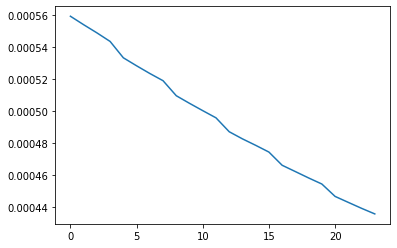

In [ ]:
plt.plot(tr_loss_hist)